In [43]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import operator

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, log_loss


# ***Kết nối dataset***

In [44]:
#Import dataset
url = 'https://raw.githubusercontent.com/KhanhGiauTen/ML_Final/bd9de59611359a50ccbbd2d6eb77669dfb4773cd/data/housing_prices.csv'
dataset = pd.read_csv(url)

# ***Kiểm tra thông tin bộ dữ liệu***

In [45]:
print(dataset.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SalePrice  Condition  
0   2008        WD     20

In [46]:
missing = dataset.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

# ***Tiền xử lí dữ liệu***

In [47]:
#fill du lieu thieu nhieu
dataset['PoolQC'] = dataset['PoolQC'].fillna('None')
dataset['MiscFeature'] = dataset['MiscFeature'].fillna('None')
dataset['Alley'] = dataset['Alley'].fillna('None')
dataset['Fence'] = dataset['Fence'].fillna('None')

In [48]:
dataset['MasVnrType'] = dataset['MasVnrType'].fillna('None')
dataset['FireplaceQu'] = dataset['FireplaceQu'].fillna('None')
dataset['LotFrontage'] = dataset['LotFrontage'].fillna(dataset['LotFrontage'].median())

In [49]:
#fill du lieu thieu it
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in garage_cols:
    dataset[col] = dataset[col].fillna('None')
dataset['GarageYrBlt'] = dataset['GarageYrBlt'].fillna(0)

bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in bsmt_cols:
    dataset[col] = dataset[col].fillna('None')

In [50]:
dataset['MasVnrArea'] = dataset['MasVnrArea'].fillna(0)
dataset['Electrical'] = dataset['Electrical'].fillna(dataset['Electrical'].mode()[0])

In [51]:
missing = dataset.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


Series([], dtype: int64)

In [52]:
#Tách kiểu dữ liệu
numeric = dataset.select_dtypes(include=[np.number]).columns
categorical = dataset.select_dtypes(exclude=[np.number]).columns

In [53]:
#Chuyển đổi các biến phân loại thành biến nhị phân
dataset = pd.get_dummies(dataset, columns=categorical, drop_first=True)

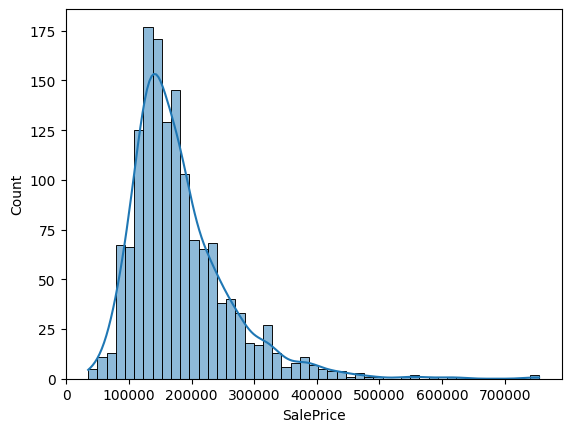

In [54]:
import seaborn as sns
import numpy as np

#Kiem tra phân phối của biến mục tiêu (SalePrice)
sns.histplot(dataset['SalePrice'], kde=True)
dataset['SalePrice'] = np.log1p(dataset['SalePrice'])

In [55]:
from sklearn.preprocessing import StandardScaler

#Chuẩẩn hóa dữ liệu
important_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']
x = dataset[important_cols]
y = dataset['SalePrice']


scaler = StandardScaler()
x = scaler.fit_transform(x)

# ***Chia dữ liệu thành các tập Train, Val, Test***

In [56]:
#Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1022, 5) Val: (144, 5) Test: (294, 5)


In [57]:
#Luu cac tap du lieu
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

# ***MODEL TRAINING***

In [58]:
#Load cac tap du lieu
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')


#Kiểm tra kích thước của các tập dữ liệu
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print(f"train: {X_train.shape[0]} ({X_train.shape[0]/len(x)*100:.1f}%)")
print(f"validation: {X_val.shape[0]} ({X_val.shape[0]/len(x)*100:.1f}%)")
print(f"test: {X_test.shape[0]} ({X_test.shape[0]/len(x)*100:.1f}%)")



Train: (1022, 5) Val: (144, 5) Test: (294, 5)
train: 1022 (70.0%)
validation: 144 (9.9%)
test: 294 (20.1%)


# **Polynomial Regression**

In [59]:
from sklearn.pipeline import make_pipeline
model_poly = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def print_metrics(name, y_true, y_pred, X):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - X.shape[1] - 1)
    rmse = np.sqrt(mse)

    print(f"\n{name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Adjusted R²: {adj_r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")

def evaluate_model_poly(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    print_metrics('Train', y_train, y_train_pred, X_train)
    print_metrics('Validation', y_val, y_val_pred, X_val)
    print_metrics('Test', y_test, y_test_pred, X_test)

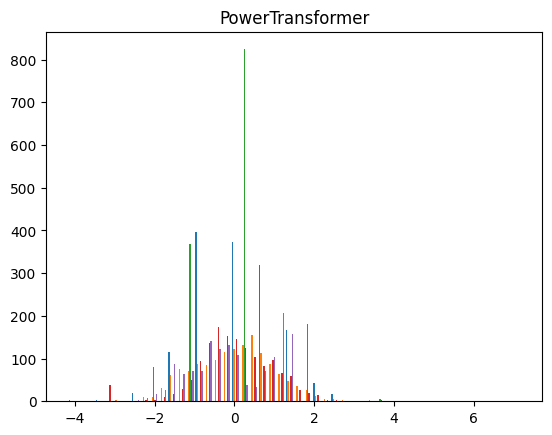

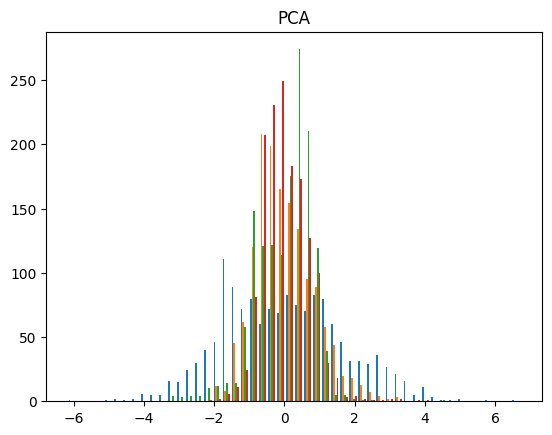

In [61]:
#Giảm chiều dữ liệu với PowerTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

data = PowerTransformer().fit_transform(x)
pca = PCA(n_components=0.95)

plt.hist(data, bins=50)
plt.title('PowerTransformer')
plt.show()

plt.hist(pca.fit_transform(data), bins=50)
plt.title('PCA')
plt.show()

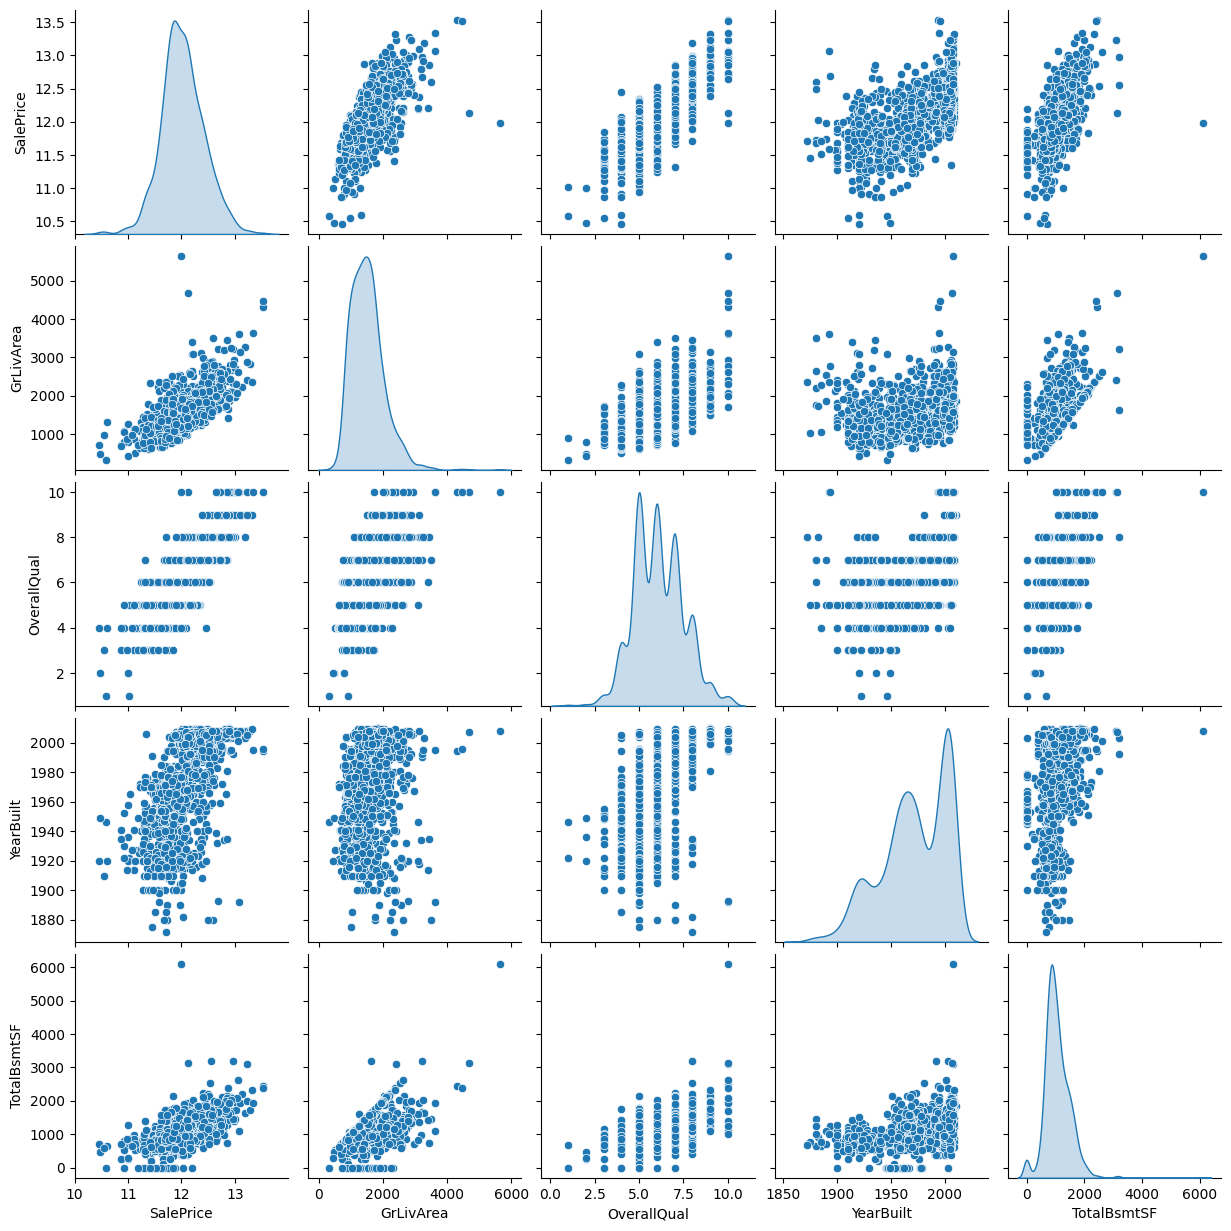

In [62]:

selected_columns = ['SalePrice', 'GrLivArea', 'OverallQual', 'YearBuilt', 'TotalBsmtSF']
sns.pairplot(dataset[selected_columns], diag_kind='kde')

In [63]:
def plot_true_vs_pred(y_true, y_pred, title='True vs Predicted'):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, edgecolors=(0, 0, 0), alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
def plot_residuals(y_true, y_pred, title='Residual Plot'):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [64]:
from sklearn.pipeline import Pipeline
# Tạo pipeline với PowerTransformer và LinearRegression
pipeline = Pipeline([
    ('power', PowerTransformer()),
    ('pca', PCA(n_components=0.95)),  # Giữ 95% phương sai
    ('model', model_poly)
])

# Huấn luyện mô hình
pipeline.fit(X_train, y_train)

# Dự đoán
y_train_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)
y_test_pred = pipeline.predict(X_test)


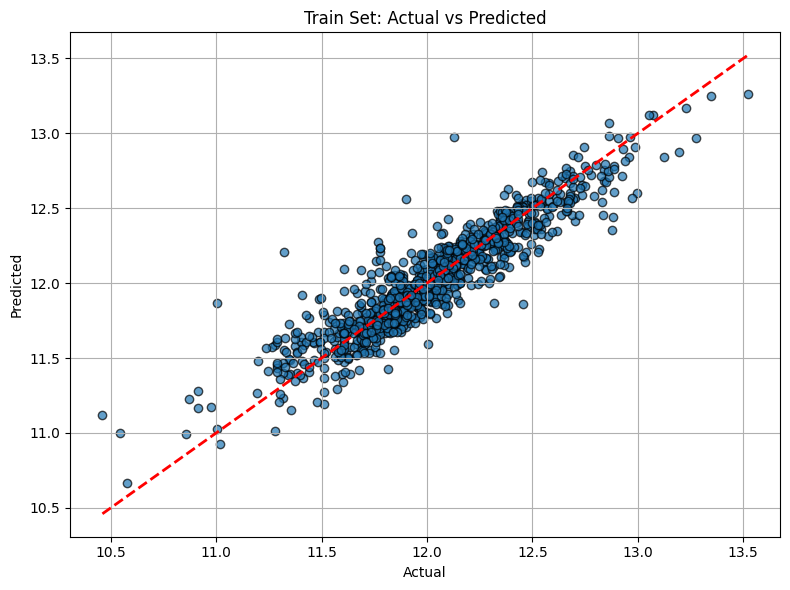

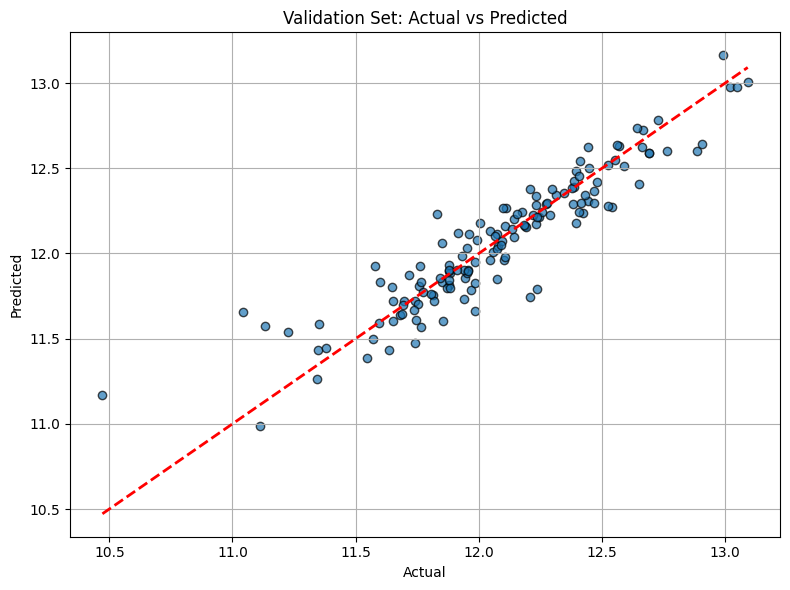

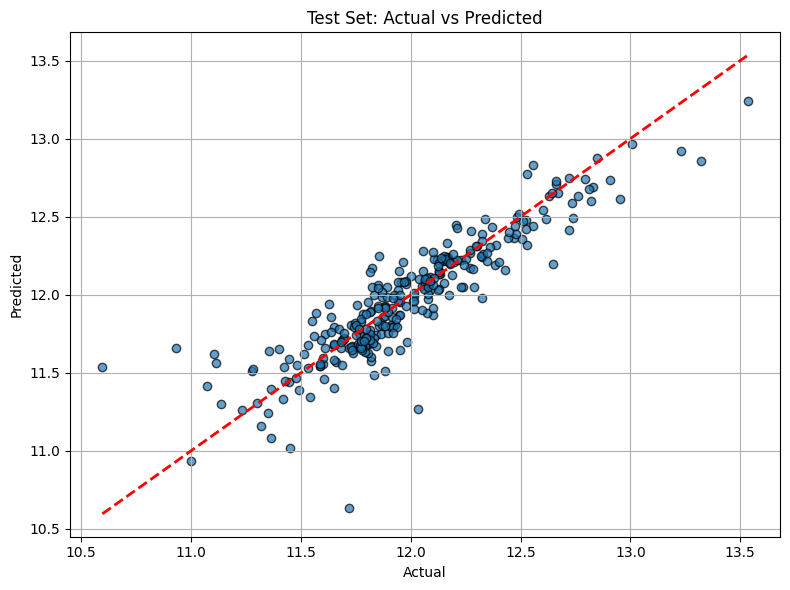

In [65]:
plot_true_vs_pred(y_train, y_train_pred, title='Train Set: Actual vs Predicted')
plot_true_vs_pred(y_val, y_val_pred, title='Validation Set: Actual vs Predicted')
plot_true_vs_pred(y_test, y_test_pred, title='Test Set: Actual vs Predicted')

In [66]:
# Chuẩn hóa và giảm chiều dữ liệu
X_power = PowerTransformer().fit_transform(x)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_power)

C:\Users\Acer\AppData\Local\Temp\ipykernel_19860\3632173826.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, cmap='viridis', s=30)


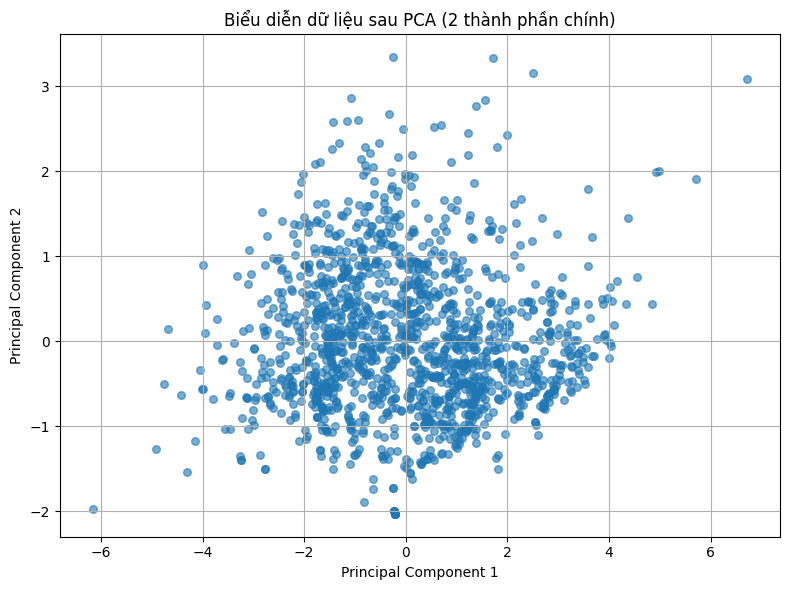

In [67]:

# Vẽ biểu đồ phân tán 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, cmap='viridis', s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Biểu diễn dữ liệu sau PCA (2 thành phần chính)')
plt.grid(True)
plt.tight_layout()
plt.show()

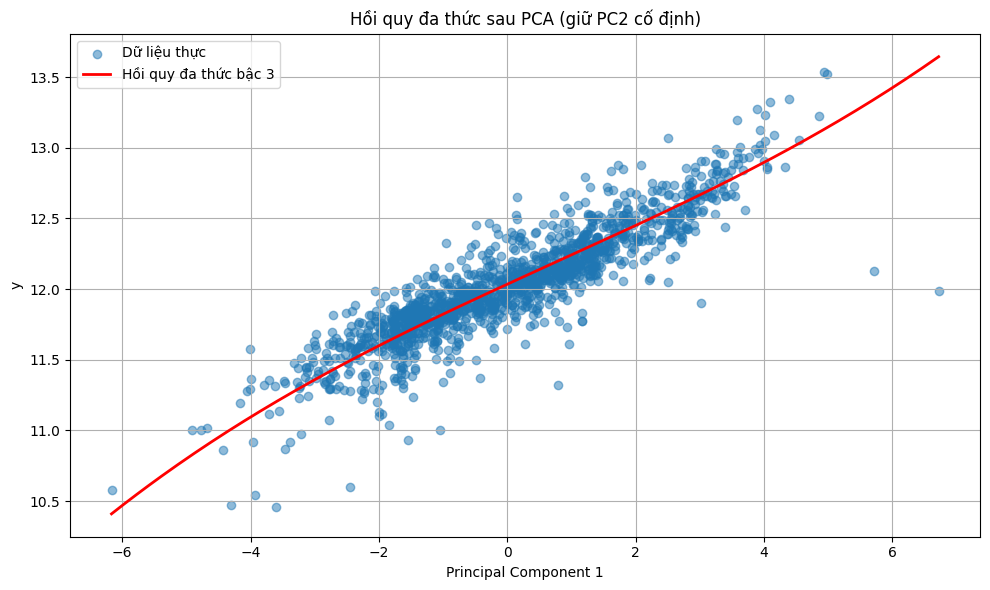


Train set:
  MSE: 0.0281
  MAE: 0.1199
  R²: 0.8239
  Adjusted R²: 0.8227
  RMSE: 0.1676

Validation set:
  MSE: 0.0261
  MAE: 0.1130
  R²: 0.8525
  Adjusted R²: 0.8472
  RMSE: 0.1615

Test set:
  MSE: 0.0324
  MAE: 0.1219
  R²: 0.8012
  Adjusted R²: 0.7977
  RMSE: 0.1800


In [68]:
# Reinitialize PolynomialFeatures to match the input shape
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_pca)  

model = LinearRegression()
model.fit(X_poly, y)

y_pred = model.predict(X_poly)

# Chọn PC1 để vẽ, giữ PC2 cố định (ở giá trị trung bình)
pc2_fixed = np.mean(X_pca[:, 1])
pc1_range = np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 200)
X_plot = np.c_[pc1_range, np.full_like(pc1_range, pc2_fixed)]

X_plot_pca = np.zeros((X_plot.shape[0], X_pca.shape[1]))
X_plot_pca[:, 0] = X_plot[:, 0]  
X_plot_pca[:, 1] = X_plot[:, 1]  

X_plot_poly = poly.transform(X_plot_pca)
y_plot = model.predict(X_plot_poly)


plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], y, alpha=0.5, label='Dữ liệu thực')
plt.plot(pc1_range, y_plot, color='red', linewidth=2, label='Hồi quy đa thức bậc 3')
plt.xlabel('Principal Component 1')
plt.ylabel('y')
plt.title('Hồi quy đa thức sau PCA (giữ PC2 cố định)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print_metrics('Train', y, y_pred, X_poly)
print_metrics('Validation', y_val, y_val_pred, X_val)
print_metrics('Test', y_test, y_test_pred, X_test)

In [69]:
from sklearn.pipeline import Pipeline
pipeline_linear = Pipeline([
    ('power', PowerTransformer()),
    ('pca', PCA(n_components=0.95)),  
    ('model', LinearRegression())
])

# Huấn luyện mô hình
pipeline_linear.fit(X_train, y_train)

# Dự đoán
y_train_pred = pipeline_linear.predict(X_train)
y_val_pred = pipeline_linear.predict(X_val)
y_test_pred = pipeline_linear.predict(X_test)

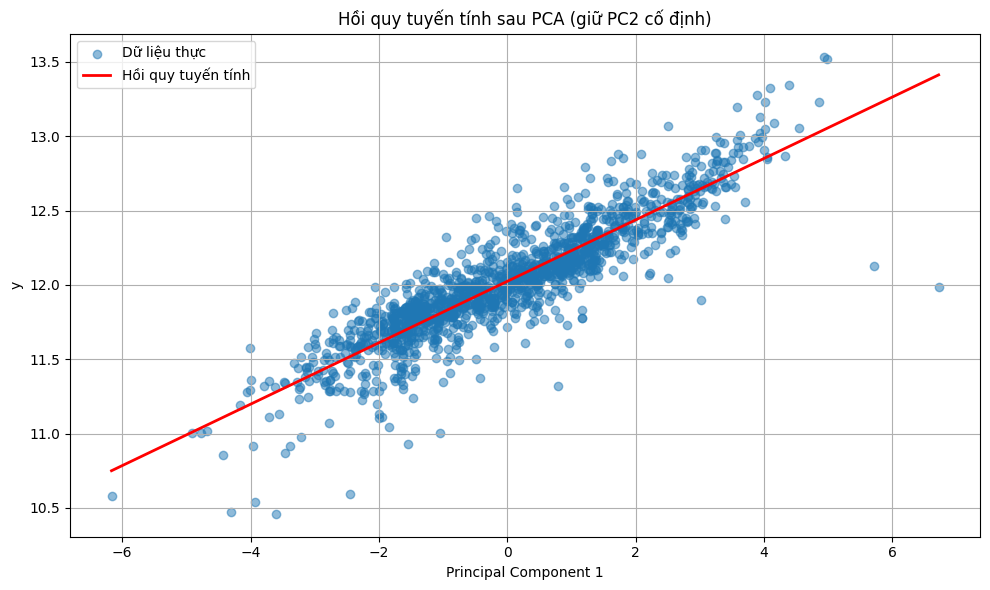


Train set:
  MSE: 0.0290
  MAE: 0.1202
  R²: 0.8126
  Adjusted R²: 0.8117
  RMSE: 0.1704

Validation set:
  MSE: 0.0235
  MAE: 0.1114
  R²: 0.8673
  Adjusted R²: 0.8625
  RMSE: 0.1532

Test set:
  MSE: 0.0289
  MAE: 0.1229
  R²: 0.8227
  Adjusted R²: 0.8196
  RMSE: 0.1700


In [70]:

model_linear= LinearRegression()
model_linear.fit(X_pca, y)

pc2_fixed = np.mean(X_pca[:, 1])
pc1_range = np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 200)
X_plot = np.c_[pc1_range, np.full_like(pc1_range, pc2_fixed)]

y_plot = model_linear.predict(X_plot)

# 4. Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], y, alpha=0.5, label='Dữ liệu thực')
plt.plot(pc1_range, y_plot, color='r', linewidth=2, label='Hồi quy tuyến tính')
plt.xlabel('Principal Component 1')
plt.ylabel('y')
plt.title('Hồi quy tuyến tính sau PCA (giữ PC2 cố định)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# In kết quả
print_metrics('Train', y_train, y_train_pred, X_train)
print_metrics('Validation', y_val, y_val_pred, X_val)
print_metrics('Test', y_test, y_test_pred, X_test)



# ***GridSearchCV***

In [71]:
from sklearn.model_selection import GridSearchCV
pipeline_gs = Pipeline([
    ('power', PowerTransformer()),
    ('pca', PCA(n_components=0.95)),  # Giữ 95% phương sai
    ('poly', PolynomialFeatures()),
    ('model', LinearRegression())
])
grid_params = {
    'poly__degree': [2, 3, 4, 5],
    'model__fit_intercept': [True, False]
}
grid_search = GridSearchCV(pipeline_gs, grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
y_train_pred_best = best_pipeline.predict(X_train)
y_val_pred_best = best_pipeline.predict(X_val)
y_test_pred_best = best_pipeline.predict(X_test)

print_metrics('Train', y_train, y_train_pred_best, X_train)
print_metrics('Validation', y_val, y_val_pred_best, X_val)
print_metrics('Test', y_test, y_test_pred_best, X_test)

Best parameters: {'model__fit_intercept': False, 'poly__degree': 3}

Train set:
  MSE: 0.0227
  MAE: 0.1092
  R²: 0.8533
  Adjusted R²: 0.8525
  RMSE: 0.1508

Validation set:
  MSE: 0.0261
  MAE: 0.1130
  R²: 0.8525
  Adjusted R²: 0.8472
  RMSE: 0.1615

Test set:
  MSE: 0.0324
  MAE: 0.1219
  R²: 0.8012
  Adjusted R²: 0.7977
  RMSE: 0.1800


# ***K-Fold***

In [72]:

from sklearn.model_selection import KFold

k_fold_model = KFold(n_splits=5, shuffle=True, random_state=42)
k = 1
score = []
for train_index, val_index in k_fold_model.split(X_train):
    X_train_k, X_val_k = X_train[train_index], X_train[val_index]
    y_train_k, y_val_k = y_train[train_index], y_train[val_index]

    pipeline.fit(X_train_k, y_train_k)

    y_val_pred_k = pipeline.predict(X_val_k)
    mse = mean_squared_error(y_val_k, y_val_pred_k)
    mae = mean_absolute_error(y_val_k, y_val_pred_k)
    r2 = r2_score(y_val_k, y_val_pred_k)
    rmse = np.sqrt(mse)

    score.append({
        'Fold': k,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'RMSE': rmse
    })

df = pd.DataFrame(score)
print(df)
    

   Fold       MSE       MAE        R2      RMSE
0     1  0.030656  0.121169  0.821867  0.175090
1     1  0.024687  0.118317  0.803299  0.157120
2     1  0.021973  0.110776  0.843175  0.148232
3     1  0.040891  0.134086  0.717280  0.202216
4     1  0.026536  0.115350  0.859780  0.162900


In [76]:
# Tính trung bình các chỉ số qua các fold
mse = np.mean([d['MSE'] for d in score])
mae = np.mean([d['MAE'] for d in score])
r2 = np.mean([d['R2'] for d in score])
rmse = np.mean([d['RMSE'] for d in score])
print(f"Average across folds: MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}, RMSE={rmse:.4f}")


Average across folds: MSE=0.0289, MAE=0.1199, R2=0.8091, RMSE=0.1691
